Data set can be found at https://snap.stanford.edu/data/twitch_ego_nets.html

In [52]:
import json
from typing import Dict, List, Tuple
from dsp import exact_densest
from dsp import greedy_charikar
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import copy

In [81]:
K = 15

# Dataset

In [40]:
Edge = Tuple[int, int]
GraphID = str

#Open and load the JSON file
file_path = "outputs/result.json"
with open(file_path, "r") as f:
    raw_data: Dict[GraphID, List[List[int]]] = json.load(f)

#Convert lists to tuple format for edges
parsed_graphs: Dict[GraphID, List[Edge]] = {
    graph_id: [tuple(edge) for edge in ginfo['edges']] 
for graph_id, ginfo in raw_data.items()}

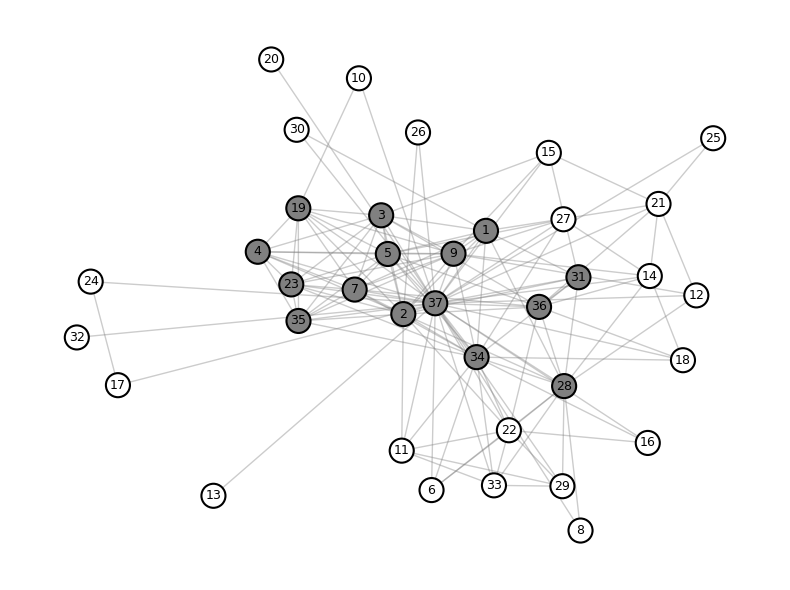

In [41]:
graph_name = '3'
K = 100  # training and testing size
# Load the first 100 graphs 
data_set = dict(list(parsed_graphs.items())[:K])
# data_set = dict(list(raw_data.items())[:K])

# Visualize the densest subgraph of a graph with at least 100 edges
# graph_iter = iter(data_set.items())

# for graph_id, edges in graph_iter:
#     if len(edges) >= 200:
#         break  # found a graph with at least 100 edges

# edges = data_set[graph_id]
# Build the graph
G = nx.Graph()
# G.add_edges_from(edges)
G.add_edges_from(raw_data[graph_name]['edges'])

# Find the densest subgraph
# Sstar, density = exact_densest(G)
Sstar = raw_data[graph_name]['damks_vlist']
density = raw_data[graph_name]['damks_density']

# Color nodes: black for densest subgraph, white for others
node_colors = ["black" if node in Sstar else "white" for node in G.nodes()]
edgecolors = ["black"] * len(G.nodes())

# Plot
# Color nodes: gray for densest subgraph, white for others
node_colors = ["gray" if node in Sstar else "white" for node in G.nodes()]
edgecolors = ["black"] * len(G.nodes())

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    edgecolors=edgecolors,
    node_size=300,
    linewidths=1.5
)

nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray', width=1.0)

nx.draw_networkx_labels(G, pos, font_size=9, font_color='black')

plt.axis("off")
plt.tight_layout()
plt.show()



# Preprocessing

In [ ]:
# Utility functions
def build_adjacency_list(edges):
    """
    Build an adjacency list from a list of edges.
    """
    adj = defaultdict(set)
    for u, v in edges:
        adj[u].add(v)
        adj[v].add(u)
    return {u: list(neighs) for u, neighs in adj.items()}

def compute_degrees_and_avg_neighbor_degrees(adj_list):
    """
    Compute the degree of each node and the average degree of its neighbors.
    """
    degrees = {node: len(neighbors) for node, neighbors in adj_list.items()}

    avg_neighbor_degrees = {}
    for node, neighbors in adj_list.items():
        if neighbors:
            total = sum(degrees.get(neighbor, 0) for neighbor in neighbors)
            avg = total / len(neighbors)
            avg_neighbor_degrees[node] = avg
        else:
            avg_neighbor_degrees[node] = 0.0

    return degrees, avg_neighbor_degrees

def compute_density(edges, S):
    """
    Compute the density of a subgraph S given the edges of the original graph.
    """
    e_s = 0
    for u, v in edges:
        if u in S and v in S:
            e_s += 1
    return e_s / len(S) if S else 0.0

def augment_ds(edges, S, epsilon = 0.1):
    """
    Our algorithm.
    Augment the densest subgraph from the partial solution S by adding epsilon * |S| / (1 - epsilon) nodes with
    the most number of edges to S.
    """
    t = defaultdict(int)
    for u, v in edges:
        if u not in S and v in S:
            t[u] += 1
        if v not in S and u in S:
            t[v] += 1
    # Sort nodes by their t values
    sorted_nodes = sorted(t.items(), key=lambda x: x[1], reverse=True)
    # Select the top |S| * epsilon / (1 - epsilon) nodes
    num_nodes_to_add = int(len(S) * epsilon / (1 - epsilon))
    nodes_to_add = [node for node, _ in sorted_nodes[:num_nodes_to_add]]
    # Add these nodes to S
    S.update(nodes_to_add)
    # Computer the density of the new S
    num_edges_in_S = 0
    for u, v in edges:
        if u in S and v in S:
            num_edges_in_S += 1
    
    if (len(S) == 0):
        density = 0
    else:
        density = num_edges_in_S / len(S)

    return S, density


In [48]:
# Function to process each graph and write node features to CSV file
def process_graph(graph_id, edges, writer):
    adj_list = build_adjacency_list(edges)
    degrees, avg_neighbor_degrees = compute_degrees_and_avg_neighbor_degrees(adj_list)
    # Compute densest subgraph
    # H, _ = exact_densest(G)
    H = raw_data[graph_id]['damks_vlist']
    H_set = set(H)
    for node in G.nodes():
        writer.writerow([
        degrees.get(node, 0),
        avg_neighbor_degrees.get(node, 0.0),
        len(G),
        int(node in H_set)])
    return True

graph_iter = iter(data_set.items())
num_graphs = 0
with open("node_features_with_labels.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "degree",
        "avg_neighbor_degree",
        "number_of_nodes",
        "is_in_densest"
    ])
    for graph_id, edges in tqdm(graph_iter, desc="Processing graphs"):
        if process_graph(graph_id, edges, writer):
            num_graphs += 1

print(f"Number of graphs processed: {num_graphs}")

Processing graphs: 0it [00:00, ?it/s]

Processing graphs: 100it [00:00, 3010.04it/s]

Number of graphs processed: 100


(4400, 3) (4400,)
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       592
           1       0.83      0.82      0.82       288

    accuracy                           0.88       880
   macro avg       0.87      0.87      0.87       880
weighted avg       0.88      0.88      0.88       880



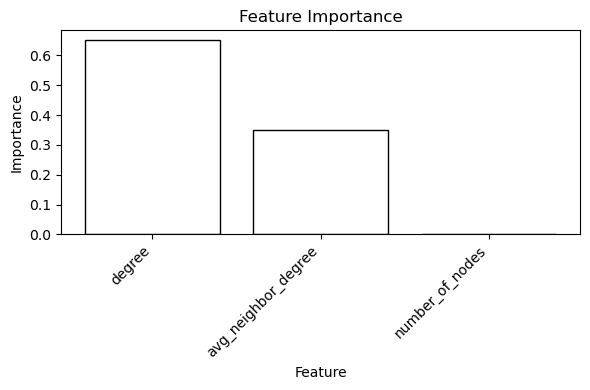

In [ ]:
# Load training data from CSV
df = pd.read_csv("node_features_with_labels.csv")
X = df[["degree", "avg_neighbor_degree", "number_of_nodes"]]
y = df["is_in_densest"]

print(X.shape, y.shape)


# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a Random Forest
clf = RandomForestClassifier(random_state=42, n_estimators=10)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importance
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(6, 4))
plt.bar(feature_names, importances, color='white', edgecolor='black')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# DamkS

In [ ]:
def graph_density(g):
    return g.number_of_edges() / g.number_of_nodes()

def greedy_damks_estimate(g: nx.Graph, k):
    h = copy.deepcopy(g)
    # Remove vertices with minimum degree until the graph has `k` vertices left
    for _ in range(h.number_of_nodes() - k):
        min_v = min(h.nodes, key=lambda v: h.degree(v))
        h.remove_node(min_v)
    # Remove vertices to check for better density
    max_d = graph_density(h)
    best_g = copy.deepcopy(h)
    for _ in range(min(k - 1, h.number_of_nodes())):
        min_v = min(h.nodes, key=lambda v: h.degree(v))
        h.remove_node(min_v)
        if graph_density(h) > max_d:
            max_d = graph_density(h)
            best_g = copy.deepcopy(h)
    return best_g

def augment_damks(edges, S, k, epsilon = 0.1):
    """
    Algorithm 2.
    Augment the densest subgraph from the partial solution S by adding epsilon * |S| / (1 - epsilon) nodes with
    the most number of edges to S; then removing nodes with smallest degree until we have k nodes.
    """
    t = defaultdict(int)
    for u, v in edges:
        if u not in S and v in S:
            t[u] += 1
        if v not in S and u in S:
            t[v] += 1
    # Sort nodes by their t values
    sorted_nodes = sorted(t.items(), key=lambda x: x[1], reverse=True)
    # Select the top |S| * epsilon / (1 - epsilon) nodes
    num_nodes_to_add = int(len(S) * epsilon / (1 - epsilon))
    nodes_to_add = [node for node, _ in sorted_nodes[:num_nodes_to_add]]
    # Add these nodes to S
    S.update(nodes_to_add)
    # Compute the density of the new S
    num_edges_in_S = 0
    for u, v in edges:
        if u in S and v in S:
            num_edges_in_S += 1
    
    if (len(S) == 0):
        density = 0
    else:
        density = num_edges_in_S / len(S)
    
    
    # vvv MODIFIED vvv
    
    g = nx.Graph()
    g.add_nodes_from(S)
    elist = []
    for u, v in edges:
        if u in S and v in S:
            elist.append((u, v))
    g.add_edges_from(elist)
    while g.number_of_nodes() > k:
        min_v = min(g.nodes, key=lambda v: g.degree(v))
        g.remove_node(min_v)

    return list(g.nodes), g.number_of_edges() / g.number_of_nodes()

Test size: 59


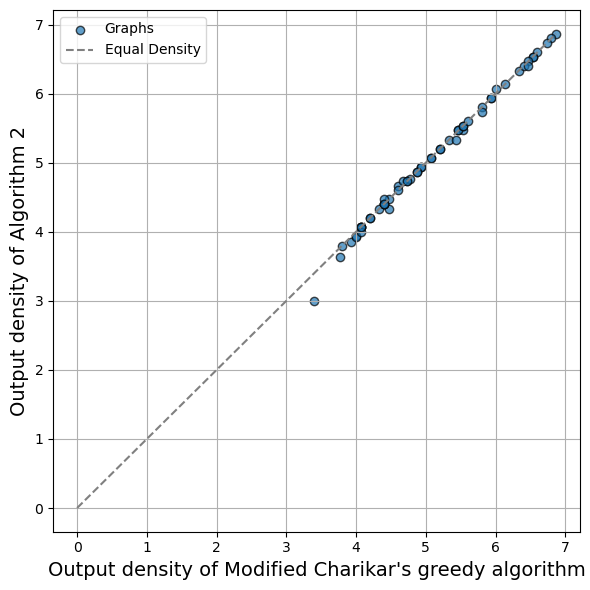

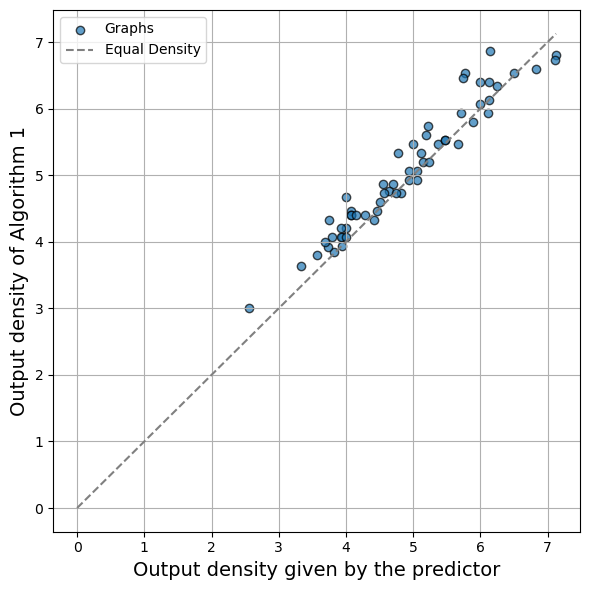

In [96]:
test_data_set = dict(list(parsed_graphs.items())[K:5*K])
graph_iter = iter(test_data_set.items())

augmented_density = []
non_augmented_density = []
peeling_density = []

# Iterate over the graphs for the first 100 graphs
test_size = 0

for graph_id, edges in test_data_set.items():
    if len(edges) < 100:
        continue
    test_size += 1

    adj_list = build_adjacency_list(edges)
    degrees, avg_neighbor_degrees = compute_degrees_and_avg_neighbor_degrees(adj_list)

    G = nx.Graph()
    G.add_edges_from(edges)
    clustering = nx.clustering(G)

    # Prepare features for classifier
    X = pd.DataFrame({
        "degree": [degrees.get(node, 0) for node in adj_list],
        "avg_neighbor_degree": [avg_neighbor_degrees.get(node, 0.0) for node in adj_list],
        "number_of_nodes": [len(adj_list)] * len(adj_list)
    })

    y_pred = clf.predict(X)
    S = {node for node, pred in zip(adj_list.keys(), y_pred) if pred == 1}
    
    # density without augmentation
    density = compute_density(edges, S)
    non_augmented_density.append(density)

    _, aug_density = augment_damks(edges, S, K, epsilon=0.2)
    augmented_density.append(aug_density)

    h = greedy_damks_estimate(G, K)
    peel_density = graph_density(h)
    peeling_density.append(peel_density)

print(f"Test size: {test_size}")

plt.figure(figsize=(6, 6))
plt.scatter(peeling_density, augmented_density, label="Graphs", alpha=0.7, edgecolor='black')

# Plot y = x line for reference
max_val = max(max(peeling_density), max(augmented_density))
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='Equal Density')

plt.xlabel("Output density of Modified Charikar's greedy algorithm", fontsize=14)
plt.ylabel("Output density of Algorithm 2", fontsize=14)
#plt.title("Augmented Learning Densest Subgraph vs. Charikar's Peeling Algorithm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 6))
plt.scatter(non_augmented_density, augmented_density, label="Graphs", alpha=0.7, edgecolor='black')

# Plot y = x line for reference
max_val = max(max(non_augmented_density), max(augmented_density))
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='Equal Density')

plt.xlabel("Output density given by the predictor", fontsize=14)
plt.ylabel("Output density of Algorithm 1", fontsize=14) 
#plt.title("Augmented Learning Densest Subgraph vs. Non-Augmented")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
# Compute % improvement of augmented over non-augmented
improvement_over_non_aug = [
    100 * (a - n) / n if n > 0 else 0
    for a, n in zip(augmented_density, non_augmented_density)
]

# Compute % improvement of augmented over Charikar peeling
improvement_over_peeling = [
    100 * (a - p) / p if p > 0 else 0
    for a, p in zip(augmented_density, peeling_density)
]

# Compute averages
avg_improvement_non_aug = np.mean(improvement_over_non_aug)
avg_improvement_peeling = np.mean(improvement_over_peeling)




# Total number of evaluated graphs
n = len(augmented_density)
# Count how often Charikar outperforms augmented
charikar_better_count = sum(
    p > a for p, a in zip(peeling_density, augmented_density)
)
# Count how often predictor (non-augmented) outperforms augmented
predictor_better_count = sum(
    n > a for n, a in zip(non_augmented_density, augmented_density)
)
# Compute percentages
charikar_better_pct = 100 * charikar_better_count / n
predictor_better_pct = 100 * predictor_better_count / n



# Compute % improvement of augmented over non-augmented
improvement_over_non_aug = [
    100 * (a - n) / n if n > 0 else 0
    for a, n in zip(augmented_density, non_augmented_density)
]

# Compute % improvement of augmented over Charikar
improvement_over_peeling = [
    100 * (a - p) / p if p > 0 else 0
    for a, p in zip(augmented_density, peeling_density)
]

# Max and min improvements
max_improve_non_aug = max(improvement_over_non_aug)
min_improve_non_aug = min(improvement_over_non_aug)

max_improve_peeling = max(improvement_over_peeling)
min_improve_peeling = min(improvement_over_peeling)

print("Reports:")
print("-----------------------------------------------------")
print(f"Average % improvement over predictor's solution: {avg_improvement_non_aug:.2f}%")
print(f"Average % improvement over Charikar's greedy: {avg_improvement_peeling:.2f}%")
print("-----------------------------------------------------")
print(f"Charikar's greedy is better on {charikar_better_count}/{n} graphs ({charikar_better_pct:.2f}%)")
print(f"Predictor's solution is better on {predictor_better_count}/{n} graphs ({predictor_better_pct:.2f}%)")
print("-----------------------------------------------------")
print(f"Charikar's greedy is better on {charikar_better_count}/{n} graphs ({charikar_better_pct:.2f}%)")
print(f"Predictor's solution is better on {predictor_better_count}/{n} graphs ({predictor_better_pct:.2f}%)")
print("-----------------------------------------------------")
print(f"Max improvement over predictor's solution: {max_improve_non_aug:.2f}%")
print(f"Worst degradation vs predictor's solution: {min_improve_non_aug:.2f}%")
print("-----------------------------------------------------")
print(f"Max improvement over Charikar's greedy: {max_improve_peeling:.2f}%")
print(f"Worst degradation vs Charikar's greedy: {min_improve_peeling:.2f}%")



Reports:
-----------------------------------------------------
Average % improvement over predictor's solution: 63.88%
Average % improvement over Charikar's greedy: -35.33%
-----------------------------------------------------
Charikar's greedy is better on 20/20 graphs (100.00%)
Predictor's solution is better on 0/20 graphs (0.00%)
-----------------------------------------------------
Charikar's greedy is better on 20/20 graphs (100.00%)
Predictor's solution is better on 0/20 graphs (0.00%)
-----------------------------------------------------
Max improvement over predictor's solution: 220.00%
Worst degradation vs predictor's solution: 26.15%
-----------------------------------------------------
Max improvement over Charikar's greedy: -17.11%
Worst degradation vs Charikar's greedy: -55.79%


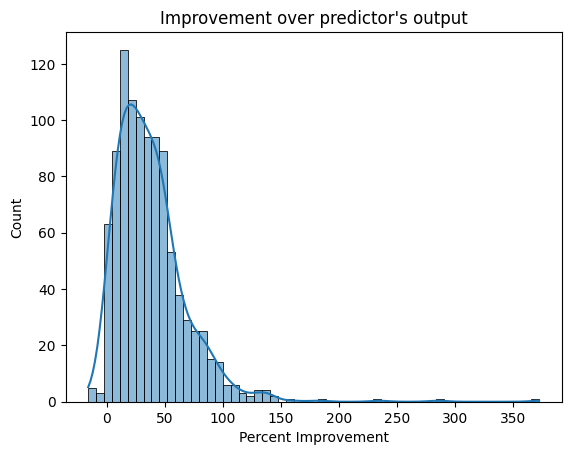

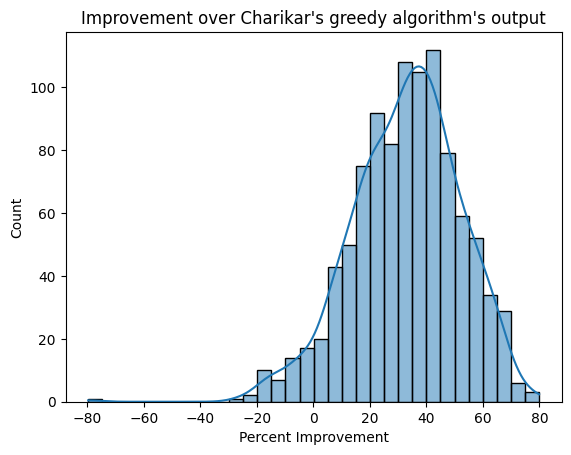

In [21]:
import seaborn as sns

sns.histplot(improvement_over_non_aug, kde=True)
plt.title("Improvement over predictor's output")
plt.xlabel("Percent Improvement")
plt.show()

sns.histplot(improvement_over_peeling, kde=True)
plt.title("Improvement over Charikar's greedy algorithm's output")
plt.xlabel("Percent Improvement")
plt.show()
